Solving track reconstruction
=======================

Up until now, we have created tracks. However, tracks should fulfill some criteria in order to make sense from a physical standpoint: It wouldn't make sense to have several tracks coming from the same hits, or to join random hits together.

Typically one uses known geometrical constraints alongside problem-specific knowledge in order to determine where to look for tracks, and how should tracks look like. Ultimately, there are five quantities one has to look after:


*   Reconstruction Efficiency: The fraction of particles we have reconstructed.
    > \# correctly reconstructed / \# real tracks

*   Clone Tracks: Tracks that are similar to other correctly reconstructed tracks.
    > \# clone tracks / \# correctly reconstructed

*   Fake Tracks: Tracks that are incorrect, either created by noise hits or by incorrectly reconstructing a track.
    > \# incorrectly reconstructed / \# all reconstructed

*   Hit purity: Fraction of hits in a track that belong to the same MC particle.
    > \# track hits in MC particle hits / \# track hits
    
*   Hit efficiency: Number of hits correctly found out of the MC particle hits in a track.
    > \# track hits in MC particle hits / \# MC particle hits

Phew, that was quite a mouthful. If you want one thing to look for at the beginning, that is to *maximize reconstruction efficiency*. First try to reconstruct as much correct as possible, and work out the other indicators one by one.

Alongside the velopix tracking project there are a few algorithms we can try:

In [1]:
# Run this if you didn't run it previously
!git clone https://github.com/dcampora/velopix_tracking.git

fatal: destination path 'velopix_tracking' already exists and is not an empty directory.


In [2]:
import sys, os
sys.path.append(os.getcwd() + "/../")
sys.path.append(os.getcwd() + "/velopix_tracking/")

import json
from event_model import event_model as em

f = open("velopix_tracking/events/velo_event_0.json")
json_data = json.loads(f.read())
event = em.event(json_data)
f.close()

Track following is a technique that reconstructs hits by visiting neighbouring modules. One first creates tracklets or *seeds* and posteriorly follows those tracks until no more hits are found.

<img src="https://github.com/dcampora/python_introduction/blob/master/velopix_tracking/doc/reco_example.png?raw=1" alt="Track follow example" />

Included with the project is a track following implementation. Let's check it out.

In [3]:
from algorithms.track_following import track_following

# Instantiate track following
track_following = track_following()

# Solve the event
tracks = track_following.solve(event)

print("Found %i tracks with track following!" % len(tracks))

Instantiating track_following solver with parameters
 max slopes: (0.7, 0.7)
 max tolerance: (0.4, 0.4)
 max scatter: 0.4

Found 148 tracks with track following!


Track following found tracks, but are these the good tracks? For that, we will need to employ a validator:

In [4]:
from validator import validator_lite as vl
vl.validate_print([json_data], [tracks])

148 tracks including        8 ghosts (  5.4%). Event average   5.4%
              velo :      126 from      134 ( 94.0%,  94.0%)        3 clones (  2.38%), purity: ( 98.83%,  98.83%),  hitEff: ( 93.89%,  93.89%)
              long :       22 from       22 (100.0%, 100.0%)        1 clones (  4.55%), purity: ( 99.52%,  99.52%),  hitEff: ( 93.80%,  93.80%)
         long>5GeV :        8 from        8 (100.0%, 100.0%)        0 clones (  0.00%), purity: (100.00%, 100.00%),  hitEff: (100.00%, 100.00%)


Results are shown for different track categories. Track categories are detector-specific, and refer to different types of tracks depending on the subdetectors they traverse, their energy, the particle decay where they originated from, direction, etc.

<img src="https://github.com/dcampora/python_introduction/blob/master/docs/track_types.png?raw=1" alt="Track follow example" style="width: 600px" />

In the previous case, you can see some tracks are "velo" tracks or "long" tracks, which you can interpret from the image above.

Exercise 2
---------------

Let's first visualize what just happened.

* Use `print_event_2d` to print the event, and then print the event with the tracks found by `track_following`.

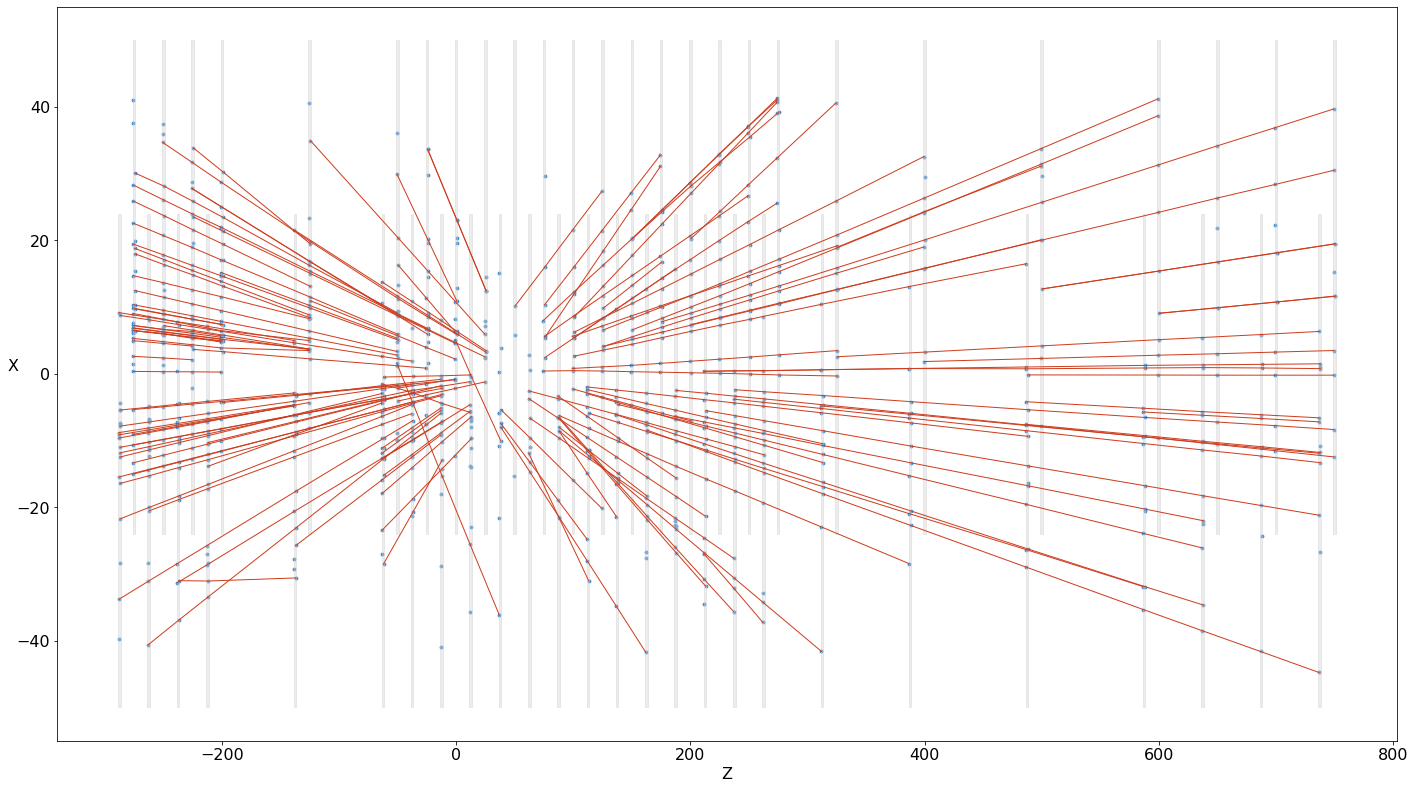

In [5]:
from visual.base import print_event_2d
%matplotlib inline
print_event_2d(event, tracks)

* The statistics we have are insufficient. Load iteratively all 10 events and run `track_following` on them. Finally, run the validator once with all the `json` data and all tracks. Do the numbers correspond with the previous ones?

In [10]:
json_data_list = []
tracks_list = []

for filename in os.listdir("velopix_tracking/events"):
  f = open("velopix_tracking/events/" + filename)
  json_data = json.loads(f.read())
  event = em.event(json_data)
  f.close()
  tracks = track_following.solve(event)

  json_data_list.append(json_data)
  tracks_list.append(tracks)

vl.validate_print(json_data_list, tracks_list)
print(len(tracks_list))

2759 tracks including      273 ghosts (  9.9%). Event average   8.5%
              velo :     2181 from     2377 ( 91.8%,  92.8%)       52 clones (  2.38%), purity: ( 98.07%,  98.20%),  hitEff: ( 94.46%,  94.58%)
              long :      640 from      654 ( 97.9%,  97.7%)       27 clones (  4.22%), purity: ( 98.34%,  98.72%),  hitEff: ( 93.95%,  94.04%)
         long>5GeV :      391 from      401 ( 97.5%,  97.2%)       20 clones (  5.12%), purity: ( 98.10%,  98.68%),  hitEff: ( 94.25%,  93.20%)
      long_strange :       24 from       26 ( 92.3%,  93.9%)        0 clones (  0.00%), purity: ( 97.80%,  96.96%),  hitEff: ( 95.15%,  97.02%)
 long_strange>5GeV :       10 from       11 ( 90.9%,  98.2%)        0 clones (  0.00%), purity: ( 99.00%,  99.33%),  hitEff: ( 94.81%,  95.07%)
        long_fromb :        9 from        9 (100.0%, 100.0%)        0 clones (  0.00%), purity: (100.00%, 100.00%),  hitEff: ( 98.57%,  98.41%)
   long_fromb>5GeV :        4 from        4 (100.0%, 100.0%)       

The fake rate is a big higher than expected. It could be that some of the tracks with less hits are incorrect.

* Remove all tracks with 3 hits and run the validator. Do the results improve? What are the tradeoffs?

In [24]:
for tracks in tracks_list:
  for track in tracks:
    if len(track.hits)==3:
      tracks.remove(track)
      
vl.validate_print(json_data_list, tracks_list)


2342 tracks including      135 ghosts (  5.8%). Event average   4.6%
              velo :     1947 from     2377 ( 81.9%,  83.1%)       40 clones (  2.05%), purity: ( 97.83%,  98.01%),  hitEff: ( 94.99%,  95.00%)
              long :      626 from      654 ( 95.7%,  95.6%)       24 clones (  3.83%), purity: ( 98.29%,  98.68%),  hitEff: ( 94.61%,  94.35%)
         long>5GeV :      387 from      401 ( 96.5%,  96.6%)       18 clones (  4.65%), purity: ( 98.07%,  98.66%),  hitEff: ( 95.06%,  93.64%)
      long_strange :       21 from       26 ( 80.8%,  88.5%)        0 clones (  0.00%), purity: ( 97.49%,  96.71%),  hitEff: ( 95.79%,  97.79%)
 long_strange>5GeV :        8 from       11 ( 72.7%,  91.2%)        0 clones (  0.00%), purity: ( 98.75%,  99.00%),  hitEff: ( 96.14%,  96.96%)
        long_fromb :        7 from        9 ( 77.8%,  78.9%)        0 clones (  0.00%), purity: (100.00%, 100.00%),  hitEff: ( 98.21%,  97.96%)
   long_fromb>5GeV :        4 from        4 (100.0%, 100.0%)       

Exercise 4
---------------

If you still have energy in you, with everything you have learned you have now the tools to attempt creating your own track reconstruction algorithm.

We will first need a function to determine whether a track looks good or bad. One such function is the *means squared error*:

* Create a means_squared_error method that gets a track as an input and calculates the MSE (https://en.wikipedia.org/wiki/Mean_squared_error) of a track.

Now that you have a function to qualify how good a track is *you are in business*. A rough approximation at a tracking in the VELO is as follows:

1. Iterate over 3 modules until you find a *triplet* of hits whose MSE is under a threshold.
2. Extrapolate those hits to the remaining modules until you find no compatible hits with the MSE method in a module.

Implement such a tracking algorithm, and have fun playing around with the data!